In [81]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [82]:
!pip install -q -U keras-tuner
import kerastuner as kt


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32

# cataract dataset
IMG_ROOT = './data/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = './data/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('./data/ODIR-5K/data.xlsx')

In [103]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [104]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'glaucoma'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[2]:  # cataract
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[1]:  # glaucoma
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= glaucoma < 2')
cat_df

,paths,glaucoma
0,./data/dataset\1_normal/NL_001.png,0
1,./data/dataset\1_normal/NL_002.png,0
2,./data/dataset\1_normal/NL_003.png,0
3,./data/dataset\1_normal/NL_004.png,0
4,./data/dataset\1_normal/NL_005.png,0
...,...,...
596,./data/dataset\3_retina_disease/Retina_096.png,0
597,./data/dataset\3_retina_disease/Retina_097.png,0
598,./data/dataset\3_retina_disease/Retina_098.png,0
599,./data/dataset\3_retina_disease/Retina_099.png,0


In [105]:
print('Number of normal and glaucoma images')
print(cat_df['glaucoma'].value_counts())

Number of normal and glaucoma images
0    601
Name: glaucoma, dtype: int64


In [106]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [107]:
def has_cataract_mentioned(text):
    if 'glaucoma' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_glaucoma'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_glaucoma'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [108]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_glaucoma']]\
        .rename(columns={'left_eye_glaucoma':'glaucoma'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_glaucoma']]\
        .rename(columns={'right_eye_glaucoma':'glaucoma'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [109]:
le_df.head()

,glaucoma,paths
0,0,./data/ODIR-5K/Training Images/0_left.jpg
1,0,./data/ODIR-5K/Training Images/1_left.jpg
2,0,./data/ODIR-5K/Training Images/2_left.jpg
3,0,./data/ODIR-5K/Training Images/3_left.jpg
4,0,./data/ODIR-5K/Training Images/4_left.jpg


In [110]:
re_df.head()

,glaucoma,paths
0,0,./data/ODIR-5K/Training Images/0_right.jpg
1,0,./data/ODIR-5K/Training Images/1_right.jpg
2,0,./data/ODIR-5K/Training Images/2_right.jpg
3,0,./data/ODIR-5K/Training Images/3_right.jpg
4,0,./data/ODIR-5K/Training Images/4_right.jpg


In [111]:
print('Number of left eye images')
print(le_df['glaucoma'].value_counts())
print('\nNumber of right eye images')
print(re_df['glaucoma'].value_counts())

Number of left eye images
0    3323
1     177
Name: glaucoma, dtype: int64

Number of right eye images
0    3351
1     149
Name: glaucoma, dtype: int64


In [112]:
def downsample(df):
    df = pd.concat([
        df.query('glaucoma==1'),
        df.query('glaucoma==0').sample(sum(df['glaucoma']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['glaucoma'].value_counts())
print('\nNumber of right eye images')
print(re_df['glaucoma'].value_counts())

Number of left eye images
1    177
0    177
Name: glaucoma, dtype: int64

Number of right eye images
1    149
0    149
Name: glaucoma, dtype: int64


In [113]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,glaucoma,paths
30,1,./data/ODIR-5K/Training Images/30_left.jpg
95,1,./data/ODIR-5K/Training Images/95_left.jpg
153,1,./data/ODIR-5K/Training Images/153_left.jpg
167,1,./data/ODIR-5K/Training Images/167_left.jpg
178,1,./data/ODIR-5K/Training Images/178_left.jpg


In [114]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,glaucoma
0,./data/dataset\1_normal/NL_001.png,0
1,./data/dataset\1_normal/NL_002.png,0
2,./data/dataset\1_normal/NL_003.png,0
3,./data/dataset\1_normal/NL_004.png,0
4,./data/dataset\1_normal/NL_005.png,0
...,...,...
1248,./data/ODIR-5K/Training Images/1571_right.jpg,0
1249,./data/ODIR-5K/Training Images/4222_right.jpg,0
1250,./data/ODIR-5K/Training Images/1873_right.jpg,0
1251,./data/ODIR-5K/Training Images/3106_right.jpg,0


In [115]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['glaucoma'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['glaucoma'])

In [116]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['glaucoma'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:13<00:00, 19.19it/s]


C:\Users\juiklee\AppData\Local\Temp\ipykernel_7176\3414707900.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  norm_list = list(train_df[0][:25])


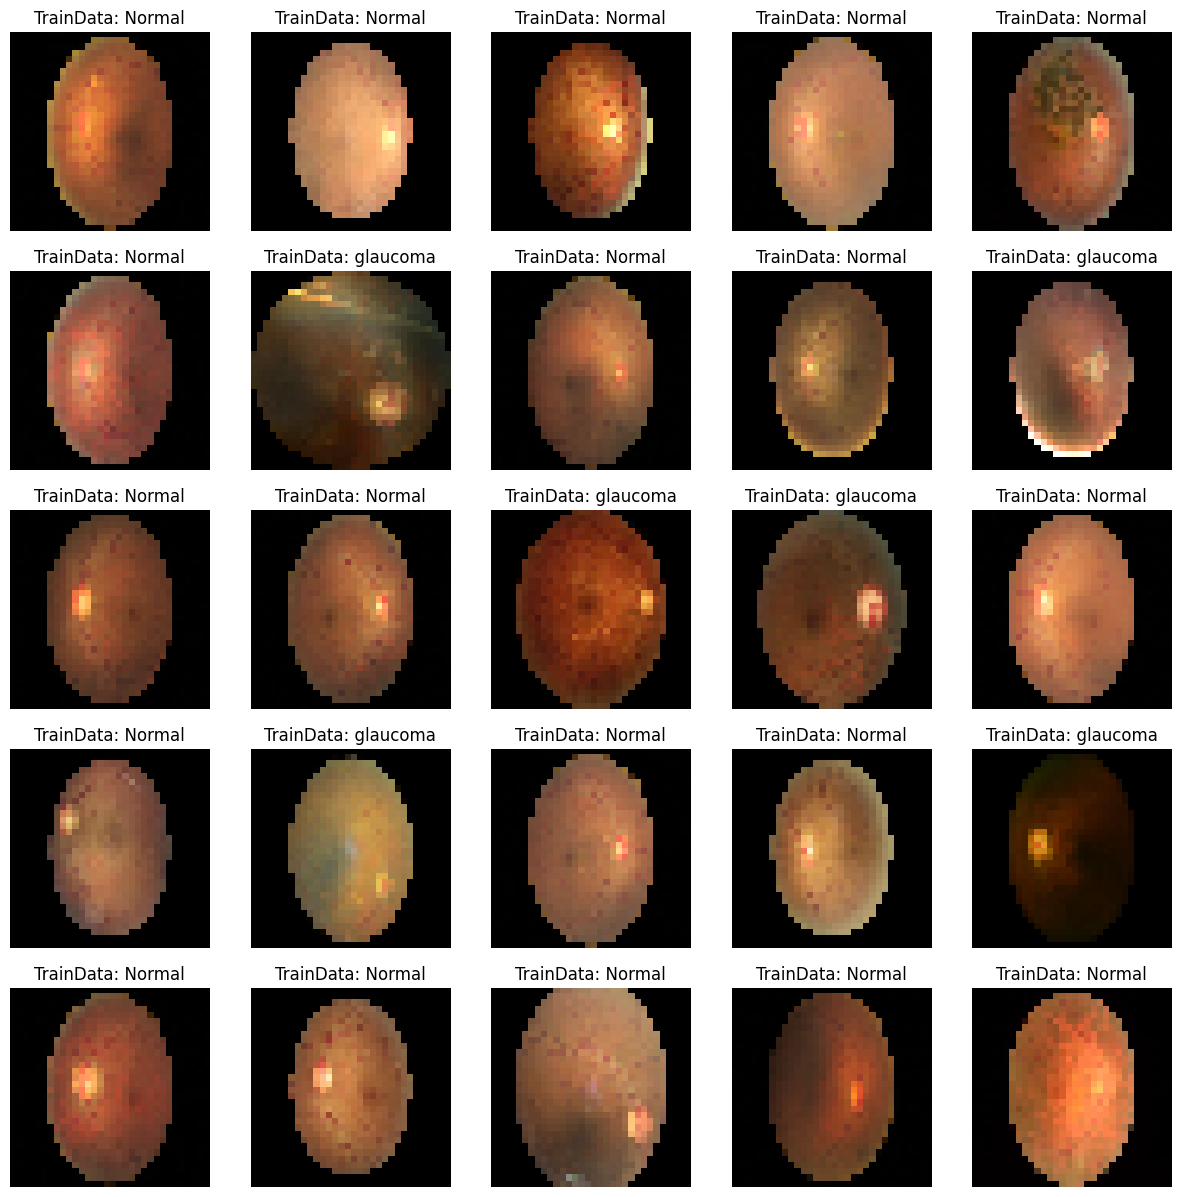

In [117]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: glaucoma')
plt.show()

C:\Users\juiklee\AppData\Local\Temp\ipykernel_7176\3690180028.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  norm_list = list(test_df[0][:25])


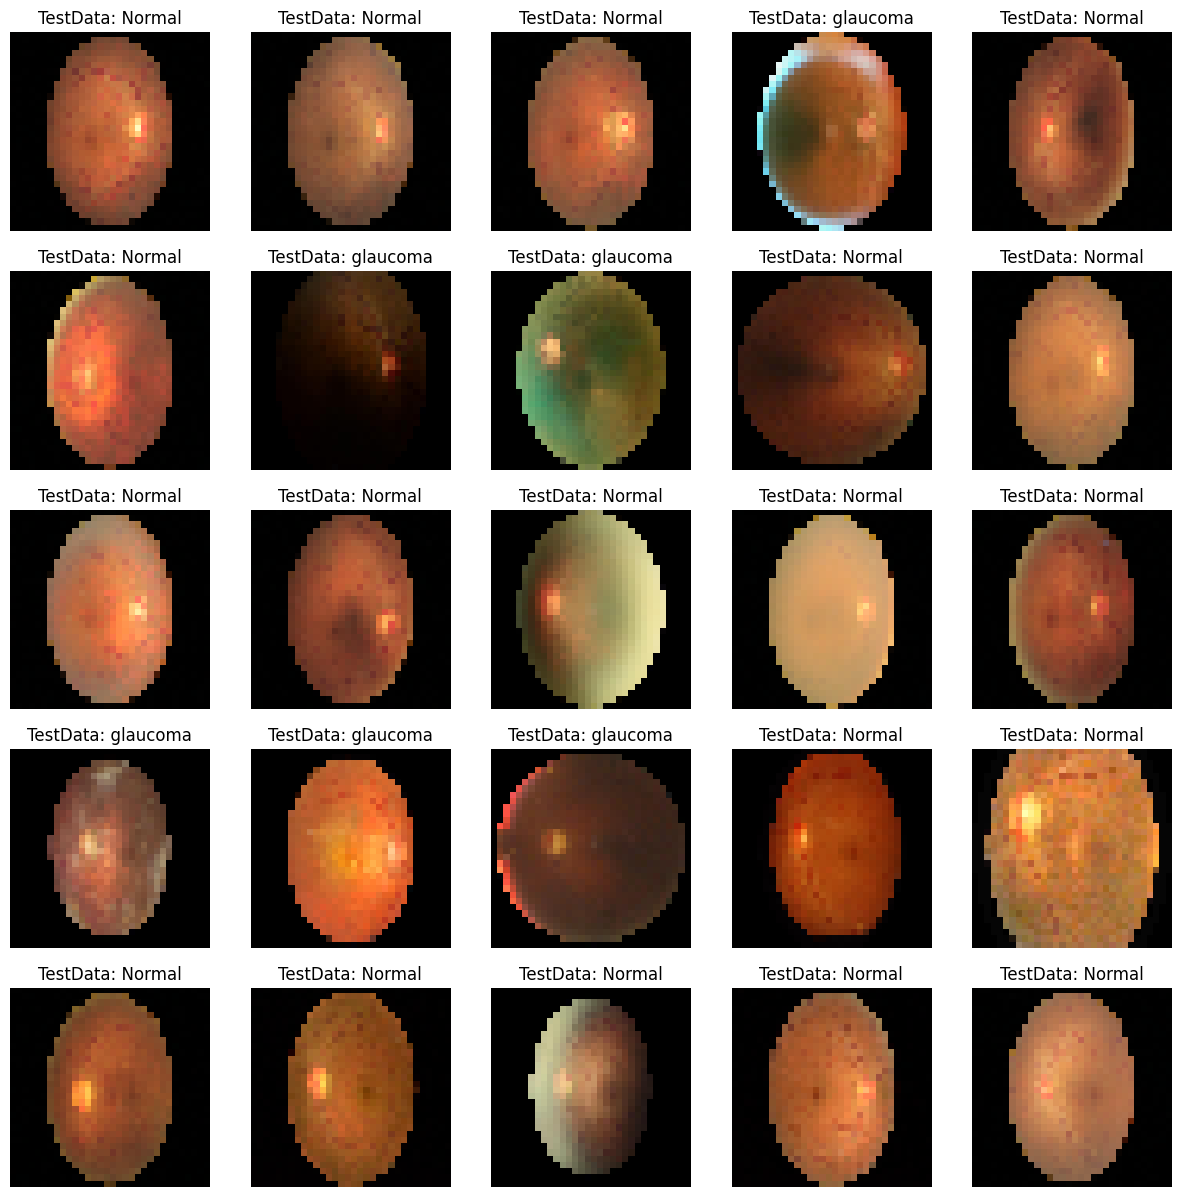

In [118]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: glaucoma')
plt.show()

In [119]:

def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnet-b0 (Functional  (None, 1, 1, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [120]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(28,28,1)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


In [121]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json


In [122]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [123]:
tuner.search(train_imgs,train_df, epochs = 10, validation_data = (test_imgs,test_df), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
96                |?                 |units
0.001             |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


ValueError: in user code:

    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\juiklee\.conda\envs\test_envs\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 28, 28), found shape=(None, 32, 32, 3)


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df)

In [ ]:
model.save("model2.h5")